# Post-Bining: Experimental Place Cells

This notebook reads an experimental dataset after:
- cell firings,
- labels,
- times,
have been binned according to a given time-step `timestep_microsec`.

Specifically, we read the files obtained after the processing function `experimental.datasets.load_place_cells` that:
- bins cell firings, times and labels according to the time-step,
- save the results in 3 files.

Plotting the binned files allows us to determine how many neurons were recorded in each experiment.

## Set up

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /Volumes/GoogleDrive/My Drive/code/neuralgeom/neuralgeom
Directory added to path:  /Volumes/GoogleDrive/My Drive/code/neuralgeom
Directory added to path:  /Volumes/GoogleDrive/My Drive/code/neuralgeom/neuralgeom


## Imports

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import neuralgeom.datasets.experimental as experimental
import neuralgeom.datasets.utils as utils

BINNED_DIR = os.path.join(os.getcwd(), "data", "binned")
print(f"The binned data is located in the directory:\n{BINNED_DIR}.")

INFO: Using pytorch backend


The binned data is located in the directory:
/Volumes/GoogleDrive/My Drive/code/neuralgeom/neuralgeom/data/binned.


## Explore data output by experimental.load_place_cells()

In [3]:
expt_id = 41
timestep_ns = int(1e6)

print(f"Loading experiment {expt_id}...")
place_cells, labels = experimental.load_place_cells(
    expt_id=expt_id, timestep_microsec=timestep_ns
)

INFO: # - Found file at data/binned/expt41_times_timestep1000000.txt! Loading...
INFO: # - Found file at data/binned/expt41_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at data/binned/expt41_labels_timestep1000000.txt! Loading...


Loading experiment 41...


In [4]:
print(place_cells.shape)
place_cells[:3]

(3882, 12)


array([[0., 4., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.]])

In [5]:
print(len(labels.values))

display(labels)

3882


,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.000
1,1,2.399831e+09,228.319574,1.598267,1.000
2,2,2.400831e+09,229.646926,6.372364,1.000
3,3,2.401831e+09,241.624300,17.123473,1.000
4,4,2.402831e+09,269.453404,32.549442,1.000
...,...,...,...,...,...
3877,3877,6.275831e+09,153.349456,23.023874,1.769
3878,3878,6.276831e+09,180.073147,32.645234,1.769
3879,3879,6.277831e+09,212.383674,20.877510,1.769
3880,3880,6.278831e+09,218.709534,1.998074,1.769


In [6]:
gain_counts = labels["gains"].value_counts()
print(gain_counts)

1.769000    2938
1.000000     219
1.300835       4
1.300840       3
1.282311       2
            ... 
1.300842       1
1.300836       1
1.300833       1
1.300830       1
1.767975       1
Name: gains, Length: 721, dtype: int64


In [7]:
labels["gains"].value_counts().is_unique

False

### Filter by velocities

In [8]:
filtered_place_cells = place_cells[labels["velocities"] > 5]
filtered_labels = labels[labels["velocities"] > 5]

print(len(filtered_place_cells))
print(len(filtered_labels))

filtered_place_cells = place_cells[labels["velocities"] > 10]
filtered_labels = labels[labels["velocities"] > 10]

print(len(filtered_place_cells))
print(len(filtered_labels))

1200
1200
935
935


### Filter by gain

In [9]:
filtered_place_cells = place_cells[labels["gains"] == 1.0]
filtered_labels = labels[labels["gains"] == 1.0]

print(len(filtered_place_cells))
print(len(filtered_labels))

219
219


In [10]:
filtered_place_cells = place_cells[labels["gains"] == 1.768999993801117]
filtered_labels = labels[labels["gains"] == 1.768999993801117]

print(len(filtered_place_cells))
print(len(filtered_labels))

2938
2938


### PCA


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(place_cells)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
projected = pca.fit_transform(place_cells)

[0.33181392 0.21530291]
0.5471168343589188


In [12]:
import torch

U, S, V = torch.pca_lowrank(torch.tensor(place_cells), q=8, center=True)

# Explore data saved in the place cells' npy, the times' txt and the labels' txt.

In [13]:
data_path = os.path.join(
    BINNED_DIR, f"expt{expt_id}_place_cells_timestep{timestep_ns}.npy"
)
times_path = os.path.join(BINNED_DIR, f"expt{expt_id}_times_timestep{timestep_ns}.txt")
labels_path = os.path.join(
    BINNED_DIR, f"expt{expt_id}_labels_timestep{timestep_ns}.txt"
)

In [14]:
print(f"Loading experiment {expt_id}...")
place_cells = np.load(data_path)

print(place_cells.shape)
print(place_cells[:3])

Loading experiment 41...
(3882, 12)
[[0. 4. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]]


In [15]:
times = pd.read_csv(times_path)
times

,2.398831347000000000e+09
0,2.399831e+09
1,2.400831e+09
2,2.401831e+09
3,2.402831e+09
4,2.403831e+09
...,...
3877,6.276831e+09
3878,6.277831e+09
3879,6.278831e+09
3880,6.279831e+09


In [16]:
labels = pd.read_csv(labels_path)
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.000
1,1,2.399831e+09,228.319574,1.598267,1.000
2,2,2.400831e+09,229.646926,6.372364,1.000
3,3,2.401831e+09,241.624300,17.123473,1.000
4,4,2.402831e+09,269.453404,32.549442,1.000
...,...,...,...,...,...
3877,3877,6.275831e+09,153.349456,23.023874,1.769
3878,3878,6.276831e+09,180.073147,32.645234,1.769
3879,3879,6.277831e+09,212.383674,20.877510,1.769
3880,3880,6.278831e+09,218.709534,1.998074,1.769


## Explore data given to the training

In [17]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    print(config_file)

Config in directory: /Volumes/GoogleDrive/My Drive/code/neuralgeom/neuralgeom/results/configs:
2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb.json
2022-12-30 14:51:00_s1_synthetic_run_moqyd9pq.json
2022-12-30 14:51:00_s1_synthetic_run_zpuaxz74.json
2022-12-30 14:51:00_s1_synthetic_run_9as5jt1n.json
2022-12-30 14:51:00_s1_synthetic_run_pnxol6cm.json
2022-12-30 14:51:00_s1_synthetic_run_yqj4d821.json
2022-12-30 14:51:00_s1_synthetic_run_t6esqyz7.json
2022-12-30 14:51:00_s1_synthetic_run_exe5ao7e.json
2022-12-30 14:51:00_s1_synthetic_run_7161z7gq.json


In [18]:
with open(
    os.path.join(CONFIG_DIR, "2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb.json"), "r"
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)

In [19]:
config

{'batch_size': 20,
 'decoder_depth': 3,
 'decoder_width': 4,
 'encoder_depth': 4,
 'encoder_width': 6,
 'lr': 0.020913288027124163,
 'dataset_name': 's1_synthetic',
 'sweep_name': '2022-12-30 14:51:00_s1_synthetic_sweep_yqmf4qye',
 'expt_id': None,
 'timestep_microsec': None,
 'smooth': None,
 'select_gain_1': None,
 'n_times': 10,
 'embedding_dim': 2,
 'distortion_amp': 0.4,
 'noise_var': 0.001,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': 'bump',
 'n_wiggles': 3,
 'radius': 1,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': 'identity',
 'device': 'cpu',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 2,
 'beta': 0.03,
 'gamma': 20,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'run_name': '2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb',
 'results_prefix': '2022-12-30 14:51:00_s1_synthetic_run_f6lf1kqb',
 'data_n_times': 10,
 'data_dim': 2}

In [20]:
data, labels, train_loader, test_loader = utils.load(config)

Dataset shape: torch.Size([10, 2]).


In [21]:
print(data.shape)
data[:3]

torch.Size([10, 2])


tensor([[ 0.9536, -0.0287],
        [ 0.7397,  0.6490],
        [ 0.2383,  1.3323]])

In [22]:
labels

,angles
0,0.000000
1,0.698132
2,1.396263
3,2.094395
4,2.792527
5,3.490659
6,4.188790
7,4.886922
8,5.585054
9,6.283185


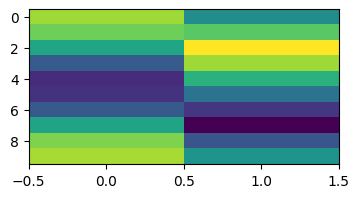

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(data[0:70, :], aspect=0.1);